In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv(r'/content/5g_iot_data.csv')

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.head(2)

,timestamp,device_id,device_type,slice_type,active_sensors,data_rate_mbps,latency_ms,qos_class,edge_enabled,auth_method,encryption_level,network_isolation,radio_resource_usage,core_network_load,upf_load,slice_hopping_detected,unauthorized_edge_access,abnormal_traffic_pattern,qos_violation,is_anomaly
0,2024-12-20 07:21:59.811021,fe7c61dd-9791-45e6-bfa7-a9a3296846aa,autonomous_vehicle,URLLC,"gps,camera,radar,lidar",811.970542,1.221285,mission_critical,True,certificates,none,shared_slice,52.992489,35.445755,61.927686,False,False,False,False,False
1,2024-12-20 07:22:36.811021,cce042bc-e908-4014-b475-c9c0b2b447bf,smart_meter,mMTC,"frequency,voltage",3.139218,94.840059,standard,False,token_based,AES_256,no_isolation,67.500466,55.673483,43.893040,False,False,False,False,False


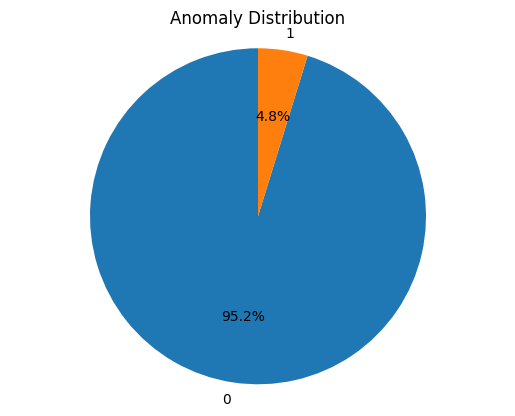

In [ ]:
plt.pie(data['is_anomaly'].value_counts(),
        labels=[0, 1],
        autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.title('Anomaly Distribution')
plt.show()

In [ ]:
X = data.drop(['is_anomaly','timestamp','device_id'], axis = 1)
y = data['is_anomaly']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,stratify=y)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder

# Label encode all categorical features and target
X_encoded = X_train.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y_train)

# Apply chi-square
selector = SelectKBest(chi2, k=5)  # Select top 5
X_new = selector.fit_transform(X_encoded, y_encoded)

# Get selected features
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['data_rate_mbps', 'latency_ms', 'radio_resource_usage',
       'core_network_load', 'upf_load'],
      dtype='object')


In [ ]:
np.save('selected_feature_names.npy',selected_features)

In [ ]:
np.load('/content/selected_feature_names.npy', allow_pickle=True) #Checking

array(['data_rate_mbps', 'latency_ms', 'radio_resource_usage',
       'core_network_load', 'upf_load'], dtype=object)

In [ ]:
X_train[selected_features]

,data_rate_mbps,latency_ms,radio_resource_usage,core_network_load,upf_load
380,1.241531,59.490757,42.004207,23.693233,57.547776
3623,240.124236,10.466108,34.076415,55.401294,50.584427
8121,392.218097,13.327638,50.638935,21.596225,63.709598
5500,406.474404,14.784613,45.193660,42.815552,49.428996
4715,83.804364,4.294996,42.269660,21.558435,53.533061
...,...,...,...,...,...
6858,72.708858,1.713959,66.187367,42.358618,43.490606
384,37.762208,2.385741,38.061932,25.470018,35.697060
8625,256.757159,12.759284,52.771685,27.340405,42.647096
360,953.680760,2.984444,35.243181,33.412567,39.882765


In [ ]:
model = GradientBoostingClassifier(learning_rate=1)

In [ ]:
model.fit(X_train[selected_features], y_train)

GradientBoostingClassifier(learning_rate=1)

In [ ]:
y_pred = model.predict(X_test[selected_features])

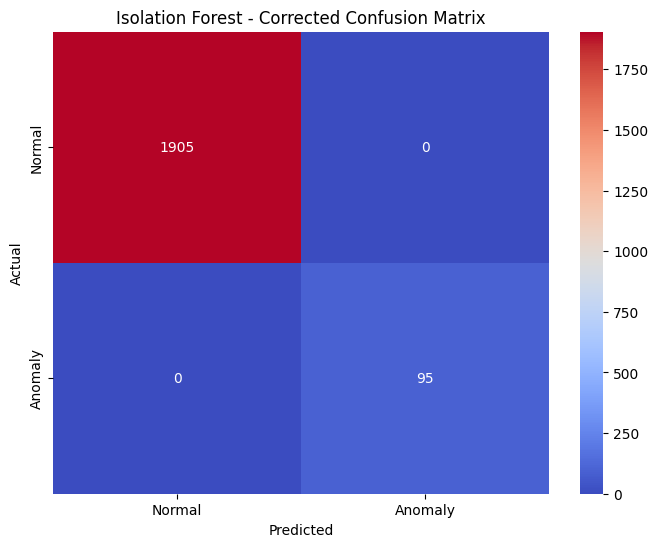

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Isolation Forest - Corrected Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1905
        True       1.00      1.00      1.00        95

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
prob_scores = model.predict_proba(X_test[selected_features])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_scores)
roc_auc = auc(fpr, tpr)

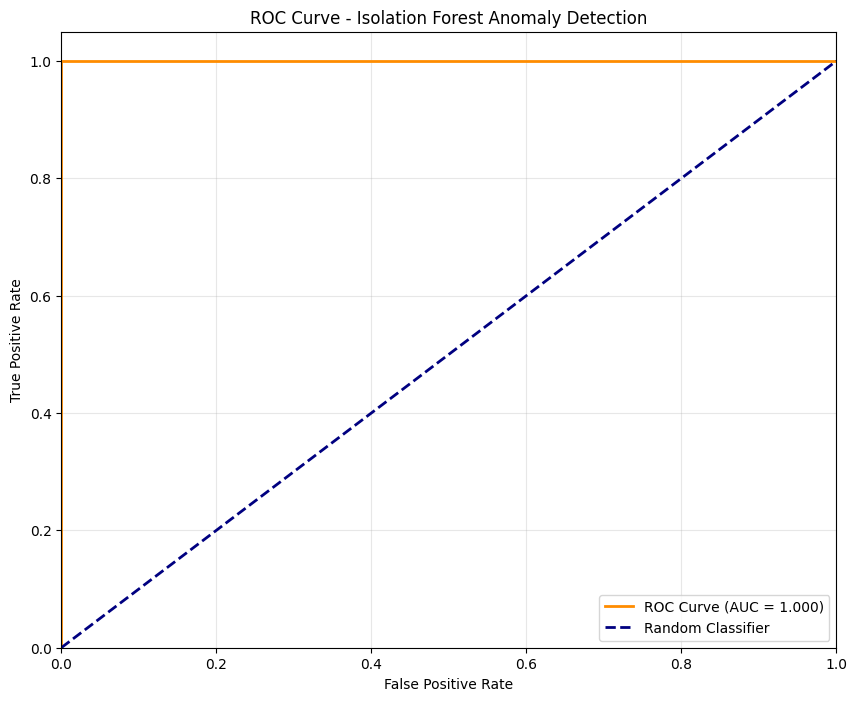

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest Anomaly Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
joblib.dump(model,'model.joblib')

['model.joblib']